# Image Description 


In [1]:
#Import all the required libraries
import numpy as np
import pandas as pd
import os
import glob
from pickle import dump,load
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import collections
import random
from tqdm import tqdm
import os
import time
import json
from PIL import Image
import pickle
import re
import nltk
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.translate.bleu_score import sentence_bleu

# Data preparation
___

# -------------------------------------------------------------------------------------------------------------

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Import the dataset and read the image into a seperate variable

images= '/content/drive/MyDrive/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [5]:
#Visualise both the images & text present in the dataset
all_imgs[:5]

['/content/drive/MyDrive/Images/387974450_bcd205daac.jpg',
 '/content/drive/MyDrive/Images/392467282_00bb22e201.jpg',
 '/content/drive/MyDrive/Images/382090166_be2c2c63e1.jpg',
 '/content/drive/MyDrive/Images/386160015_d4b31df68e.jpg',
 '/content/drive/MyDrive/Images/390992102_67fa31b22f.jpg']

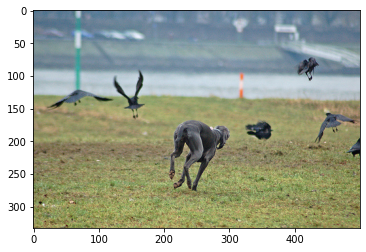

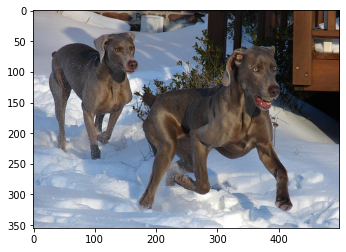

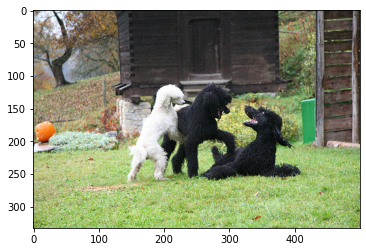

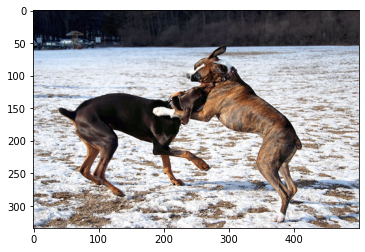

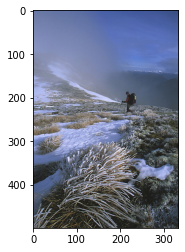

In [6]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(all_imgs[i])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    text = open(filename, 'rb').read().decode('utf-8').split('\n')
    
    return text

text_file = "/content/drive/MyDrive/captions.txt"
doc = load_doc(text_file)
print(doc[:5])

['image,caption', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']


In [8]:
ID = []
ann = []
for i in range(1,len(doc)-1):
    a = doc[i].split(',')[0]
    b = doc[i].split(',')[-1]
    ID.append(a)
    ann.append(b)

In [9]:
all_imgs[0]
img_id = []
for i in range(0 , len(ID)):
    p = images+'/'+ID[i]
    img_id.append(p)

In [10]:
all_img_id= ID         #store all the image id here
all_img_vector= img_id #store all the image path here
annotations= ann       #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...


In [11]:
cap_vocab = []
nltk.download('stopwords')
from nltk.corpus import stopwords
for i in range(0,len(annotations)):
    cap = re.sub('[^a-zA-Z]',' ',df['Captions'][i])
    ps = PorterStemmer() #creating an object of the Porter Stemmer Class
    all_stopwords = stopwords.words('english')#storing all the stopwords of eng in a variable
    cap = cap.lower() #to convert everything to lowercase
    cap = cap.split()
    cap = [ps.stem(word) for word in cap if not word in set(all_stopwords)]
    cap = ' '.join(cap)
    cap_vocab.append(cap)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
#Create the vocabulary & the counter for the captions
#write your code here
vocabulary= {}

for sentence in cap_vocab:
    for word in sentence.split():
        if word not in vocabulary:
            vocabulary[word] = 0
        else :
            vocabulary[word] += 1

val_count=Counter(vocabulary)

In [13]:
key = list(vocabulary.keys())
values = list(vocabulary.values())

In [14]:
vocab_data = pd.DataFrame(list(zip(key,values)), columns =['word', 'count'])

In [15]:
#Visualise the top 30 occuring words in the captions
vocab_data.sort_values(by=['count'],ascending=False,inplace = True)
vocab_data.reset_index(drop=True,inplace=True)
top_30 = vocab_data[:30]

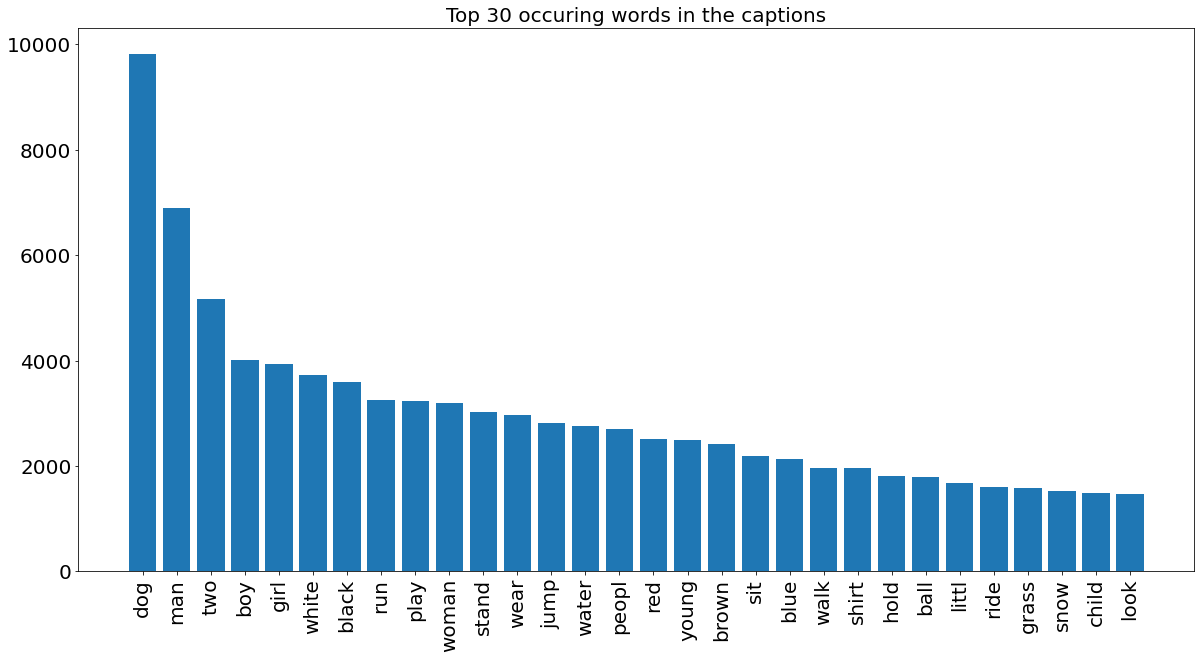

In [16]:
plt.figure(figsize=(20,10))
plt.bar(top_30['word'],top_30['count'])
plt.yticks(fontsize=20)
plt.xticks(top_30["word"],rotation=90,fontsize=20)
plt.title("Top 30 occuring words in the captions",fontsize=20)
plt.show()

In [ ]:
#Create a list which contains all the captions
annotations= [] #write your code here

for val in df["Captions"]:
    caption = "<start> "+val+" <end>"
    annotations.append(caption)
#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path= df.Path #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # Resize images into the shape of (299, 299)
    img = tf.keras.applications.inception_v3.preprocess_input(img) # format for InceptionV3.
    return img, image_path

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the image using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [ ]:
# Get unique images
encode_train = sorted(set(all_img_vector))


image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 506/506 [03:31<00:00,  2.40it/s]


In [ ]:
#Create a list which contains all the captions
annotations= [] #write your code here

for val in df["Captions"]:
    caption = "<start> "+val+" <end>"
    annotations.append(caption)
#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path= df.Path #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(annotations)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(all_img_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32360, 32360, 8095, 8095)

In [ ]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
test_dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
test_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# -------------------------------------------------------------------------------------------------------------

# Modelling Building
___

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = top_k + 1 #top 5,000 words +1
train_num_steps = len(img_name_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(img_name_val) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim) #build your Dense layer  

    def call(self, features):
        features = self.fc(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features) #  Dense layer relu activation
        return features

In [ ]:
encoder = CNN_Encoder(embedding_dim)

### Attention model

In [ ]:
class Attention_Model(tf.keras.Model):
  def __init__(self, units):
    super(Attention_Model, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
    self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
    self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1

  def call(self, features, hidden):
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
    attention_weights = tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)

    context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
    context_vector = tf.reduce_sum(context_vector, axis=1)  # reduce the shape to (batch_size, embedding_dim)

    return context_vector, attention_weights

### Decoder

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units) #build your Dense layer
    self.fc2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer

    self.attention = Attention_Model(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model

    x = self.embedding(x) # embedding your input to shape: (batch_size, 1, embedding_dim)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)

    output, state = self.gru(x) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)

    x = self.fc1(output)

    x = tf.reshape(x, (-1, x.shape[2])) # shape : (batch_size * max_length, hidden_size)

    x = self.fc2(x) # shape : (batch_size * max_length, vocab_size)

    return x, state, attention_weights

  def reset_state(self, batch_size): # mentioned reset_state in trainer function 
    return tf.zeros((batch_size, self.units))

In [ ]:
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# -------------------------------------------------------------------------------------------------------------

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

### Training step functions

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

## <font color='red'>Two Models have been trained in seprate 'run time' with seprate evaluation

## Model 1 training

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7276
Epoch 1 Batch 100 Loss 1.5250
Epoch 1 Batch 200 Loss 1.4327
Epoch 1 Batch 300 Loss 1.2025
Epoch 1 Batch 400 Loss 1.1332
Epoch 1 Batch 500 Loss 1.0224
Epoch 1 Loss 1.357753
Time taken for 1 epoch 148.68813467025757 sec

Epoch 2 Batch 0 Loss 1.2134
Epoch 2 Batch 100 Loss 1.0433
Epoch 2 Batch 200 Loss 1.0269
Epoch 2 Batch 300 Loss 1.0225
Epoch 2 Batch 400 Loss 1.0709
Epoch 2 Batch 500 Loss 0.9722
Epoch 2 Loss 1.064739
Time taken for 1 epoch 88.01566910743713 sec

Epoch 3 Batch 0 Loss 1.1140
Epoch 3 Batch 100 Loss 0.9963
Epoch 3 Batch 200 Loss 0.8951
Epoch 3 Batch 300 Loss 0.8453
Epoch 3 Batch 400 Loss 1.0206
Epoch 3 Batch 500 Loss 0.8216
Epoch 3 Loss 0.967801
Time taken for 1 epoch 85.12143850326538 sec

Epoch 4 Batch 0 Loss 0.9532
Epoch 4 Batch 100 Loss 0.9032
Epoch 4 Batch 200 Loss 0.8420
Epoch 4 Batch 300 Loss 0.8407
Epoch 4 Batch 400 Loss 0.9691
Epoch 4 Batch 500 Loss 0.8062
Epoch 4 Loss 0.900755
Time taken for 1 epoch 84.41585659980774 sec

Epoch 5 Batch 0

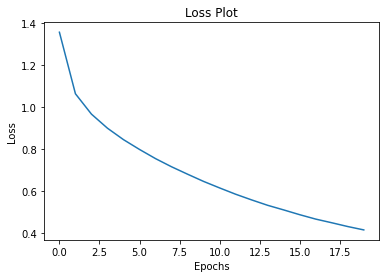

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Testing step functions

In [ ]:
@tf.function
def test_step(img_tensor, target):
  loss = 0
    
  #write your code here to do the testing steps
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
def test_loss_cal(test_dataset):
  total_loss = 0
  for (batch, (img_tensor, target)) in enumerate(test_dataset):
    batch_loss, t_loss = test_step(img_tensor, target)
    total_loss += t_loss
    avg_test_loss=total_loss / test_num_steps

    #write your code to get the average loss result on your test data
    
    return avg_test_loss

## Model 2 training

In [ ]:
loss_plot1 = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot1.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [02:47<39:10, 167.87s/it]

For epoch: 1, the train loss is 0.438, & test loss is 0.003
Time taken for 1 epoch 167.6824095249176 sec

Test loss has been reduced from 100.000 to 0.003


 13%|█▎        | 2/15 [04:20<31:28, 145.24s/it]

For epoch: 2, the train loss is 0.354, & test loss is 0.002
Time taken for 1 epoch 92.28860592842102 sec

Test loss has been reduced from 0.003 to 0.002


 20%|██        | 3/15 [05:48<25:37, 128.11s/it]

For epoch: 3, the train loss is 0.319, & test loss is 0.002
Time taken for 1 epoch 88.0026650428772 sec

Test loss has been reduced from 0.002 to 0.002


 27%|██▋       | 4/15 [07:16<21:16, 116.02s/it]

For epoch: 4, the train loss is 0.304, & test loss is 0.002
Time taken for 1 epoch 87.69741296768188 sec

Test loss has been reduced from 0.002 to 0.002


 33%|███▎      | 5/15 [08:44<17:55, 107.58s/it]

For epoch: 5, the train loss is 0.292, & test loss is 0.002
Time taken for 1 epoch 87.75627541542053 sec

Test loss has been reduced from 0.002 to 0.002


 40%|████      | 6/15 [10:16<15:28, 103.12s/it]

For epoch: 6, the train loss is 0.285, & test loss is 0.002
Time taken for 1 epoch 92.6895363330841 sec



 47%|████▋     | 7/15 [11:44<13:08, 98.55s/it] 

For epoch: 7, the train loss is 0.276, & test loss is 0.002
Time taken for 1 epoch 87.74821400642395 sec

Test loss has been reduced from 0.002 to 0.002


 53%|█████▎    | 8/15 [13:12<11:07, 95.30s/it]

For epoch: 8, the train loss is 0.268, & test loss is 0.002
Time taken for 1 epoch 87.58861422538757 sec

Test loss has been reduced from 0.002 to 0.002


 60%|██████    | 9/15 [14:39<09:17, 92.96s/it]

For epoch: 9, the train loss is 0.261, & test loss is 0.002
Time taken for 1 epoch 87.37554407119751 sec

Test loss has been reduced from 0.002 to 0.002


 67%|██████▋   | 10/15 [16:06<07:35, 91.09s/it]

For epoch: 10, the train loss is 0.253, & test loss is 0.001
Time taken for 1 epoch 86.58833408355713 sec

Test loss has been reduced from 0.002 to 0.001


 73%|███████▎  | 11/15 [17:33<05:59, 89.92s/it]

For epoch: 11, the train loss is 0.250, & test loss is 0.002
Time taken for 1 epoch 87.21254372596741 sec



 80%|████████  | 12/15 [19:00<04:26, 89.00s/it]

For epoch: 12, the train loss is 0.245, & test loss is 0.002
Time taken for 1 epoch 86.83621072769165 sec



 87%|████████▋ | 13/15 [20:27<02:56, 88.33s/it]

For epoch: 13, the train loss is 0.242, & test loss is 0.001
Time taken for 1 epoch 86.76958203315735 sec



 93%|█████████▎| 14/15 [21:55<01:28, 88.13s/it]

For epoch: 14, the train loss is 0.238, & test loss is 0.002
Time taken for 1 epoch 87.64515280723572 sec



100%|██████████| 15/15 [23:22<00:00, 93.49s/it]

For epoch: 15, the train loss is 0.233, & test loss is 0.001
Time taken for 1 epoch 87.25393462181091 sec



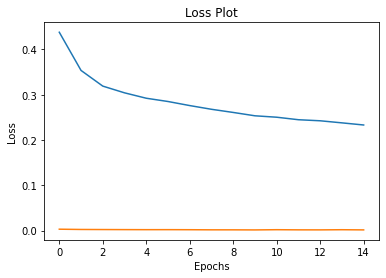

In [ ]:
plt.plot(loss_plot1)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Model Evaluation
___

# -------------------------------------------------------------------------------------------------------------

## Model 1 Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> men wearing hats walk on the street <end>
Prediction Caption: man in a blue hat and green shirt is holding a crowd <end>


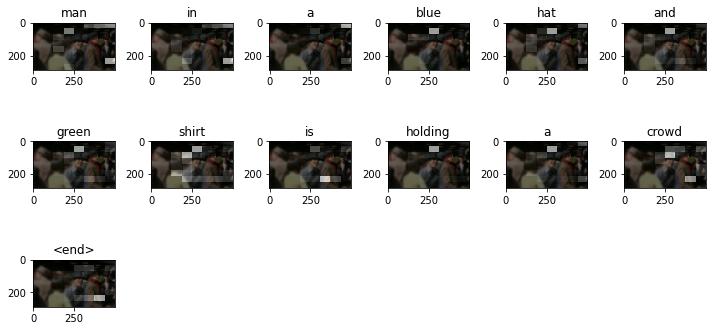

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


### BLEU score

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score: 59.46035575013605
Real Caption: two dogs race through a field
Prediction Caption: a dog is playing with brown dog


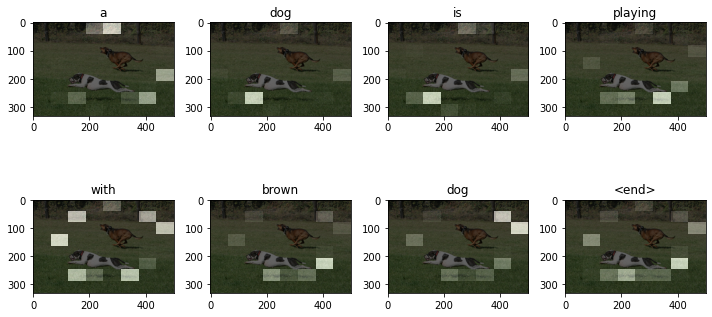

In [ ]:

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
Image.open(image)

## Model 2 Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

Real Caption: <start> two black and white dogs running in a field <end>
Prediction Caption: dog and dog with a ball in his mouth <end>


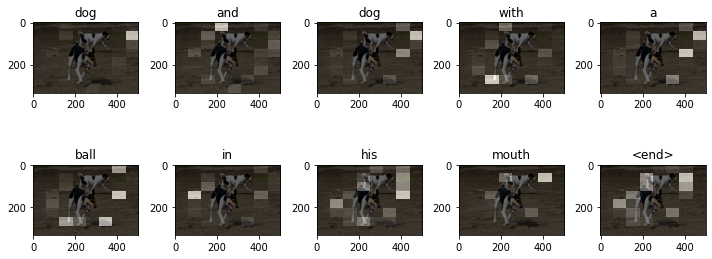

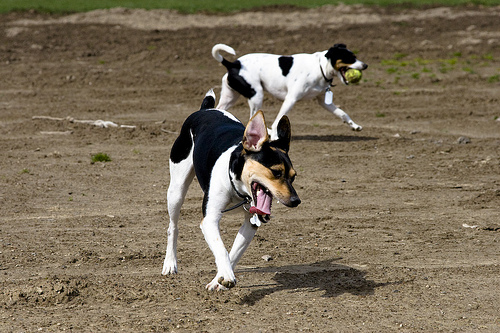

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

### BLEU score

BELU score: 27.901593935858273
Real Caption: a man on bicycle riding down a rocky hill
Prediction Caption: a man rides his bike riding down a rocky trail


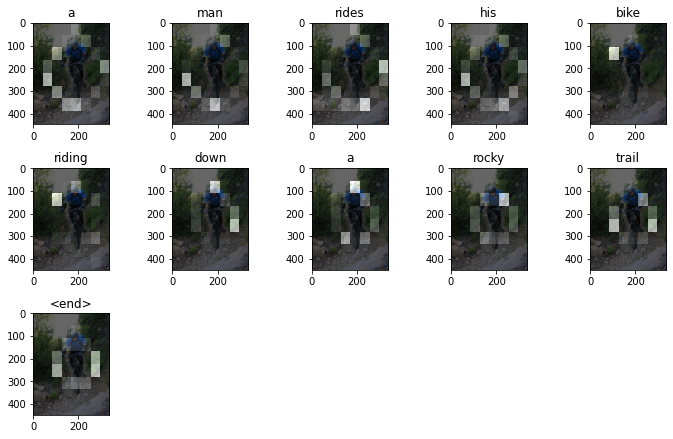

In [ ]:

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)

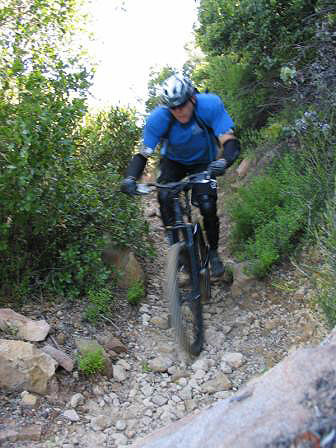

In [ ]:
Image.open(image)